In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'INFY.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,0.794921,0.796679,0.791015,0.796679,0.524797,204800
1996-01-02,0.794921,0.798828,0.793457,0.793457,0.522674,204800
1996-01-03,0.798828,0.798828,0.798828,0.798828,0.526212,102400
1996-01-04,0.791015,0.794921,0.791015,0.793554,0.522738,307200
1996-01-05,0.784179,0.784179,0.784179,0.784179,0.516563,51200
...,...,...,...,...,...,...
2024-04-25,1420.000000,1444.900024,1420.000000,1438.449951,1438.449951,9089398
2024-04-26,1439.699951,1445.400024,1427.000000,1430.250000,1430.250000,8062444
2024-04-29,1429.949951,1439.800049,1428.250000,1434.750000,1434.750000,5055957


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 17s 11ms/step - loss: 0.0032
Epoch 2/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0012
Epoch 3/50
221/221 [==============================] - 3s 12ms/step - loss: 0.0010
Epoch 4/50
221/221 [==============================] - 2s 10ms/step - loss: 0.0011
Epoch 5/50
221/221 [==============================] - 2s 11ms/step - loss: 8.4148e-04
Epoch 6/50
221/221 [==============================] - 2s 10ms/step - loss: 8.6355e-04
Epoch 7/50
221/221 [==============================] - 3s 12ms/step - loss: 8.1921e-04
Epoch 8/50
221/221 [==============================] - 3s 12ms/step - loss: 6.9649e-04
Epoch 9/50
221/221 [==============================] - 2s 11ms/step - loss: 6.9580e-04
Epoch 10/50
221/221 [==============================] - 2s 11ms/step - loss: 6.6999e-04
Epoch 11/50
221/221 [==============================] - 2s 10ms/step - loss: 7.4659e-04
Epoch 12/50
221/221 [==============================] - 3s 12ms/step

1/1 [==============================] - 0s 18ms/step


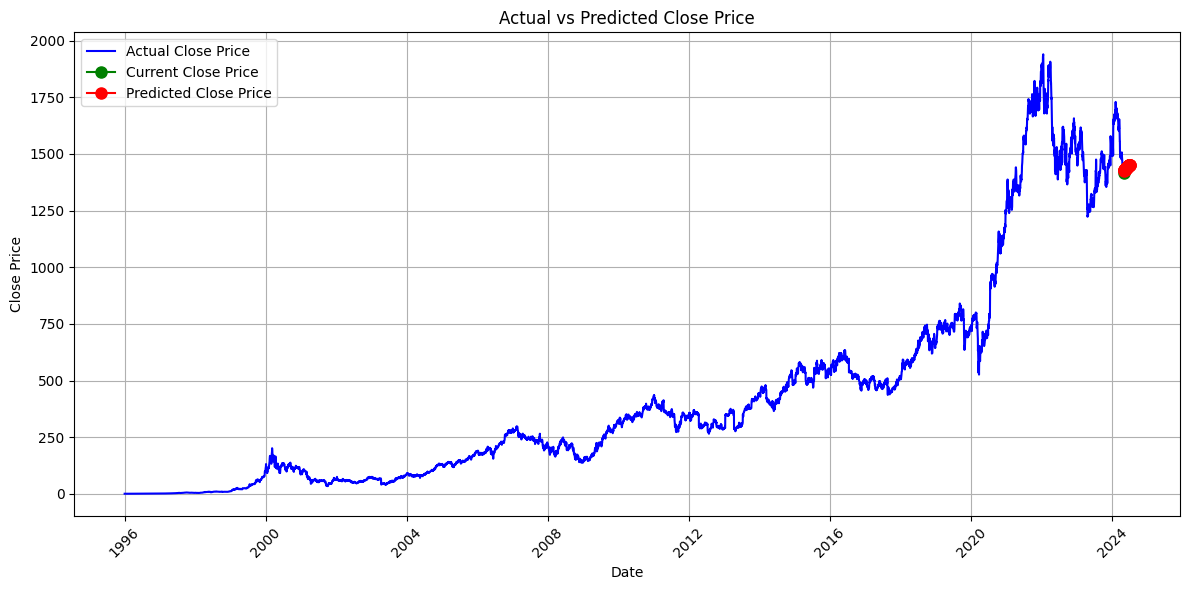

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([1430.2357, 1427.6136, 1426.8229, 1427.0245, 1427.6375, 1428.3716,
       1429.1018, 1429.7871, 1430.4215, 1431.0139, 1431.5754, 1432.1174,
       1432.6476, 1433.1718, 1433.6935, 1434.2136, 1434.7334, 1435.2521,
       1435.769 , 1436.2839, 1436.7957, 1437.3037, 1437.8073, 1438.3065,
       1438.8009, 1439.2902, 1439.774 , 1440.2529, 1440.7264, 1441.195 ,
       1441.6583, 1442.1165, 1442.5697, 1443.0178, 1443.4608, 1443.899 ,
       1444.3324, 1444.7606, 1445.1844, 1445.6033, 1446.0175, 1446.427 ,
       1446.8317, 1447.2317, 1447.6273, 1448.0184, 1448.4048, 1448.7869,
       1449.1643, 1449.5376, 1449.9064, 1450.2706, 1450.631 , 1450.9868,
       1451.3386, 1451.686 , 1452.0294, 1452.3687, 1452.7039, 1453.035 ],
      dtype=float32)

In [10]:
model.save('INFY.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'INFY.pkl')

['INFY.pkl']